In [359]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

SAMPLE_NUMBER = 213

from sklearn.linear_model import LinearRegression # linear regression
from sklearn.model_selection import train_test_split # split dataset into train & testing
from sklearn.metrics import mean_squared_error # calculate error

from sklearn.model_selection import train_test_split # split dataset into train & testing
from sklearn.metrics import max_error, mean_absolute_error # calculate error

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.linear_model import LinearRegression # linear regression

In [395]:
def read_filename(filename):

	# read table
	df = pd.read_csv(filename, sep='\t', decimal='.', header=None)

	# EG, FILENAME='PL_PC_records/PL and PC record-535-b-2.txt' --> ID_STRING='535-b-2.txt'
	id_string = filename.split('/')[2]
	cc = id_string.split('_') # split into parts with - inbetween

	print (cc)

	wavelength = cc[0] # wavelength
	location = cc[3] # background (b) or nv-center (nv)
	voltage = cc[2]

	# file has rows for columns, thus transpose
	df = df.transpose()

	# assign column meaning
	df['Laser Power (V)'] = df[0] # the header became the index after transposition
	df['PL (counts/s)'] = df[1]
	df['PC (pA)'] = df[2]

	# make the index a simple counter
	df = df.reset_index()

	# keep columns of interest
	df = df[['Laser Power (V)', 'PL (counts/s)', 'PC (pA)']]

	# assign identifiers to dataframe
	df['Wavelength'] = int(wavelength)
	df['Location'] = location
	df['Voltage'] = voltage

	df['Laser Power (V)'] = df['Laser Power (V)'].astype(float)
	df['PL (counts/s)'] = df['PL (counts/s)'].astype(float)
	df['PC (pA)'] =  df['PC (pA)'].astype(float)

	return df, wavelength, location, voltage

def read_experiment(fg, bg, plot=True):
	nv_df_0V, _ , _ , _ = read_filename(fg)
	nv_df_0V_BG, _ , _ , _ = read_filename(bg)

	# showcase Laser Power x PL
	if plot:
		fig, (ax1,ax2) = plt.subplots(1,2, figsize=(7,2.5))  # 1 row, 2 columns
		nv_df_0V.plot.scatter(x='Laser Power (V)', y='PL (counts/s)', ax=ax1, title=f"NV-Center {SAMPLE_NUMBER}  - Voltage to PhotoLuminesence")
		nv_df_0V_BG.plot.scatter(x='Laser Power (V)', y='PL (counts/s)', ax=ax2, title=f"Background {SAMPLE_NUMBER}  - Voltage to PhotoLuminesence")

	# plt.plot(X_test, y_pred,color='k')

	return nv_df_0V, nv_df_0V_BG

def read_experiment_w_exp_volt(wavelength, experiment_n, volt):
	
	filename_fg = f'./SAT_CURVE/{wavelength}_NV_{volt}_fg_{experiment_n}.txt'
	filename_bg = f'./SAT_CURVE/{wavelength}_NV_{volt}_bg_1.txt'

	df_fg, df_bg = read_experiment(filename_fg, filename_bg, False)

	df = fit_background(df_fg, df_bg, False)

	df['wavelength'] = wavelength
	df['experiment #'] = experiment_n
	df['sample'] = SAMPLE_NUMBER

	return df

def fit_background(df_nv_fg, df_nv_bg, plot=True):
	# fit background PL(V) function, should be linear
	X = df_nv_bg['Laser Power (V)'].to_numpy()
	y = df_nv_bg['PL (counts/s)'].to_numpy()

	# reshape data - [a,b,c,d] -> [[a], [b], [c], [d]] (because we have 1 feature for X)
	X = X.reshape(-1, 1)

	# split dataset into 80% for training, 20% for testing
	X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) 

	# fit regression
	reg = LinearRegression().fit(X_train, y_train)

	# predict on unseen values (X_test)
	y_pred = reg.predict(X_test)

	# plot input values, and fit
	if plot:
		fig, (ax1) = plt.subplots(1,1, figsize=(5,2.5))  # 1 row, 2 columns
		plt.scatter(X_train, y_train,color='r') 
		plt.plot(X_test, y_pred,color='k')

	print("mean_absolute_error:", mean_absolute_error(y_test,y_pred), " - max_error:", max_error(y_test,y_pred))

	# conver the column into a readily base for regressing
	laser_power_nv = df_nv_fg['Laser Power (V)'].to_numpy().reshape(-1,1)

	# apply PL-count Regression
	df_nv_fg['PL_background'] = reg.predict(laser_power_nv)

	# subtract background counts from NV counts
	df_nv_fg['PL_actual (#/s)'] = df_nv_fg['PL (counts/s)'] - df_nv_fg['PL_background']

	if plot:
		fig, (ax1) = plt.subplots(1,1, figsize=(5,2.5))  # 1 row, 2 columns
		df_nv_fg.plot.scatter(x='Laser Power (V)', y='PL_actual (#/s)', ax=ax1, title=f"NV-Center {SAMPLE_NUMBER} - Saturation Curve - Power vs PhotoLuminesence")

	return df_nv_fg

def map_to_mw(wavelength, df):

	# pick out wavelength
	fit = wavelength_dict[wavelength]

	# apply converion to df
	df['Laser Power (mW)'] = fit.predict(df['Laser Power (V)'].to_numpy().reshape(-1,1))

	return df

def perform_fit(curve_fit, df):
	# df_0V = nv_df_0V
	fit_0, _ = get_fit_params(func_to_fit, df)
	fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
	df.plot.scatter(x='Laser Power (mW)', y='PL_actual (#/s)', c='green', ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - Laser Power (V) vs PhotoLuminesence")

	x_1 = df['Laser Power (mW)'].to_numpy()

	plt.plot(x_1, curve_fit(x_1, *fit_0), 'g--', c='green', label='NV 0V - fit: b=%5.3f, c=%5.3f, d=%5.3f, e=%5.3f' % tuple(fit_0))

	ax1.set_title(f"#{SAMPLE_NUMBER} NV-Center - Natural Log PL -  Voltage Sweep at varying laser powers - 535nm")
	ax1.set_xlabel("Laser Power (mW)")
	ax1.set_ylabel("Photoluminescence (#/s)")
	ax1.legend()
	ax1.grid(True)

	plt.legend()

def perform_fit_ax(curve_fit, ax1, df, color='green', scatter=True, legend=False):
	# df_0V = nv_df_0V
	fit_0, _ = get_fit_params(curve_fit, df)

	if scatter:
		df.plot.scatter(x='Laser Power (mW)', y='PL_actual (#/s)', c=color, ax=ax1, legend=True, title=f"NV-Center {SAMPLE_NUMBER} - Laser Power (V) vs PhotoLuminesence")

	x_1 = df['Laser Power (mW)'].to_numpy()
	x_1.sort()

	plt.plot(x_1, curve_fit(x_1, *fit_0), 'g--', c=color, label='NV 0V - fit: b=%5.3f, c=%5.3f, d=%5.3f, e=%5.3f' % tuple(fit_0))

	ax1.set_title(f"#{SAMPLE_NUMBER} NV-Center - Natural Log PL -  Voltage Sweep at varying laser powers - 535nm")
	ax1.set_xlabel("Laser Power (mW)")
	ax1.set_ylabel("Photoluminescence (#/s)")

	if legend:
		ax1.legend()
	ax1.grid(True)

	if legend:
		plt.legend()

def get_fit_params(func_to_fit, df):
	# data
	x = df['Laser Power (mW)'].to_numpy()
	y = df['PL_actual (#/s)'].to_numpy()

	# function fit
	popt, pcov = curve_fit(func_to_fit, x, y,
		p0=[100000, 10, 10, 10],
		bounds=((0, 0, 0, 0), (np.inf, np.inf, np.inf, np.inf)),
		maxfev=100000
	)
	
	return popt, pcov

## Laser Power - V to mW Conversion

In [343]:
# 535 - laser power fitting
x = np.array([0.10334, 3.20574]).reshape(-1, 1)
y = [1.51800, 60.6]
laser_power_v_to_mW_535 = LinearRegression().fit(x, y)

# 540 - laser power fittingx
x = np.array([0.413991, 8.34689]).reshape(-1, 1)
y = [2.86, 61.1]
laser_power_v_to_mW_540 = LinearRegression().fit(x, y)

# 545 - laser power fittingx
x = np.array([0.394525, 5.7888]).reshape(-1, 1)
y = [3.82, 60.2]
laser_power_v_to_mW_545 = LinearRegression().fit(x, y)

# 550 - laser power fittingx
x = np.array([0.361688, 9.14476]).reshape(-1, 1)
y = [2.16, 58.9]
laser_power_v_to_mW_550 = LinearRegression().fit(x, y)

wavelength_dict = {
	535: laser_power_v_to_mW_535,
	540: laser_power_v_to_mW_540,
	545: laser_power_v_to_mW_545,
	550: laser_power_v_to_mW_550,
}

In [334]:
wavelength_dict[545].predict([[0.3]])

array([2.83204156])

## Read Raw Data

In [420]:
directory = 'SAT_CURVE'

dfs_wavelength = {}

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    # checking if it is a file
    if os.path.isfile(f):

        # skip if this isn't out file
        filename = f.split('/')[1]
        params = filename.split('_')

        if (len(params)<5):
            continue

        wavelength = params[0]
        voltage = params[2]
        exp = params[4].split('.')[0]

        print (wavelength, voltage, exp)

        df = read_experiment_w_exp_volt(wavelength, exp, voltage)

        df = map_to_mw(int(wavelength), df)

        if wavelength not in dfs_wavelength:
            dfs_wavelength[wavelength] = {}

            if voltage not in dfs_wavelength[wavelength]:
                dfs_wavelength[wavelength][voltage] = []
                dfs_wavelength[wavelength][voltage].append(df)
            else:
                dfs_wavelength[wavelength][voltage].append(df)

        else:

            if voltage not in dfs_wavelength[wavelength]:
                dfs_wavelength[wavelength][voltage] = []
                dfs_wavelength[wavelength][voltage].append(df)
            else:
                dfs_wavelength[wavelength][voltage].append(df)

540 m10V 1
['540', 'NV', 'm10V', 'fg', '1.txt']
['540', 'NV', 'm10V', 'bg', '1.txt']
mean_absolute_error: 6200.764854949003  - max_error: 15363.674544975773
540 0V 8
['540', 'NV', '0V', 'fg', '8.txt']
['540', 'NV', '0V', 'bg', '1.txt']
mean_absolute_error: 4796.833172751605  - max_error: 14745.49104334449
540 m10V 6
['540', 'NV', 'm10V', 'fg', '6.txt']
['540', 'NV', 'm10V', 'bg', '1.txt']
mean_absolute_error: 6200.764854949003  - max_error: 15363.674544975773
540 m10V 4
['540', 'NV', 'm10V', 'fg', '4.txt']
['540', 'NV', 'm10V', 'bg', '1.txt']
mean_absolute_error: 6200.764854949003  - max_error: 15363.674544975773
540 m10V 5
['540', 'NV', 'm10V', 'fg', '5.txt']
['540', 'NV', 'm10V', 'bg', '1.txt']
mean_absolute_error: 6200.764854949003  - max_error: 15363.674544975773
540 m10V 1
['540', 'NV', 'm10V', 'fg', '1.txt']
['540', 'NV', 'm10V', 'bg', '1.txt']
mean_absolute_error: 6200.764854949003  - max_error: 15363.674544975773
540 m10V 2
['540', 'NV', 'm10V', 'fg', '2.txt']
['540', 'NV', 'm1

Gather ensemble data across voltages

In [446]:
nv_540_0v = dfs_wavelength['540']['0V'][0].append(dfs_wavelength['540']['0V'][1:])
nv_540_m10v = dfs_wavelength['540']['m10V'][0].append(dfs_wavelength['540']['m10V'][1:])
nv_540_10v = dfs_wavelength['540']['10V'][0].append(dfs_wavelength['540']['10V'][1:])

Clean data

In [444]:
dfs_wavelength['540']['0V'][0]

,Laser Power (V),PL (counts/s),PC (pA),Wavelength,Location,Voltage,PL_background,PL_actual (#/s),wavelength,experiment #,sample,Laser Power (mW)
0,0.039023,75562.218891,-0.474567,540,fg,0V,70977.246248,4584.972643,540,8,213,0.107143
1,0.039187,76081.490224,-0.517006,540,fg,0V,70985.139567,5096.350657,540,8,213,0.108347
2,0.039401,76800.447490,-0.530487,540,fg,0V,70995.439385,5805.008105,540,8,213,0.109918
3,0.040094,77429.620563,-0.484917,540,fg,0V,71028.793469,6400.827094,540,8,213,0.115006
4,0.043037,77826.259421,-0.453319,540,fg,0V,71170.440035,6655.819386,540,8,213,0.136612
...,...,...,...,...,...,...,...,...,...,...,...,...
95,8.459555,507268.265056,-0.454724,540,fg,0V,476257.381919,31010.883137,540,8,213,61.927139
96,8.581940,506091.258933,-0.425093,540,fg,0V,482147.770959,23943.487974,540,8,213,62.825638
97,8.651941,512049.479398,-0.433654,540,fg,0V,485516.918511,26532.560887,540,8,213,63.339556
98,8.687323,518389.143178,-0.472721,540,fg,0V,487219.853879,31169.289299,540,8,213,63.599316


In [445]:
for w, voltages in dfs_wavelength.items(): # wavelength
	for v, experiments in voltages.items(): # voltage
		for ii, df in enumerate(experiments): # experiment
			
			dfs_wavelength[w][v][ii] = df.loc[df['PL (counts/s)'] > 0,:]

## toMw & Fitting 

In [447]:
def func_to_fit(x, b, c, d, e):
    return ((x**2) + b*x) / (c*(x**2) + d*x + e)

km = 5.3728E-6
kn = 66.756E-6

def daria_fit(x, e, a, b, c):
	d = km/kn  # <-- FIXED RATIO
	# d = kn/km  # <-- Correct RATIO	
	
	return (e) / (1 + (1/(a*x)) + ((c*x)/(1+b*x)) + ((d)/(1+b*x) ) )

### Ensemble Fit

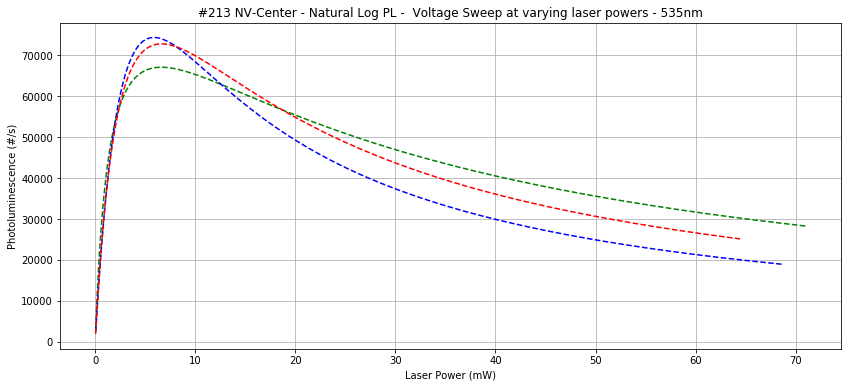

In [455]:
nv_540_0v = map_to_mw(540, nv_540_0v)
nv_540_m10v = map_to_mw(540, nv_540_m10v)
nv_540_10v = map_to_mw(540, nv_540_10v)

# fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
# perform_fit_ax(func_to_fit, ax1, nv_540_0v, 'green', scatter=True)
# perform_fit_ax(func_to_fit, ax1, nv_540_m10v, 'blue', scatter=True)
# perform_fit_ax(func_to_fit, ax1, nv_540_10v, 'red', scatter=True)

fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
perform_fit_ax(daria_fit, ax1, nv_540_0v, 'green', scatter=False)
perform_fit_ax(daria_fit, ax1, nv_540_m10v, 'blue', scatter=False)
perform_fit_ax(daria_fit, ax1, nv_540_10v, 'red', scatter=False)

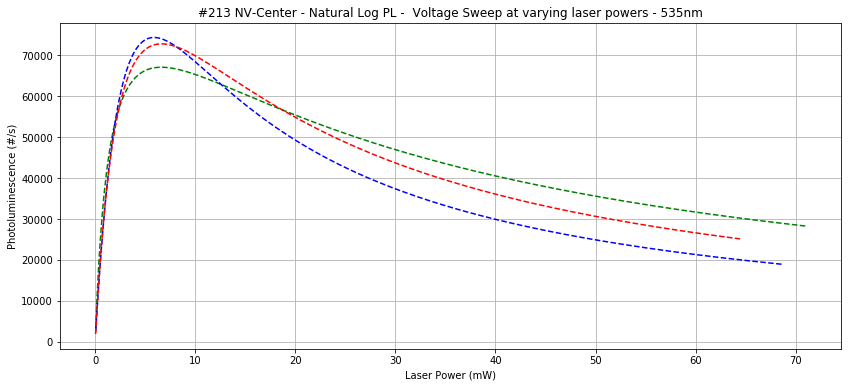

In [456]:
nv_540_0v = map_to_mw(540, nv_540_0v)
nv_540_m10v = map_to_mw(540, nv_540_m10v)
nv_540_10v = map_to_mw(540, nv_540_10v)

fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
perform_fit_ax(func_to_fit, ax1, nv_540_0v, 'green', scatter=False)
perform_fit_ax(func_to_fit, ax1, nv_540_m10v, 'blue', scatter=False)
perform_fit_ax(func_to_fit, ax1, nv_540_10v, 'red', scatter=False)

### Saturation Curves - Varying Voltage

Text(0, 0.5, 'Photoluminescence (#/s)')

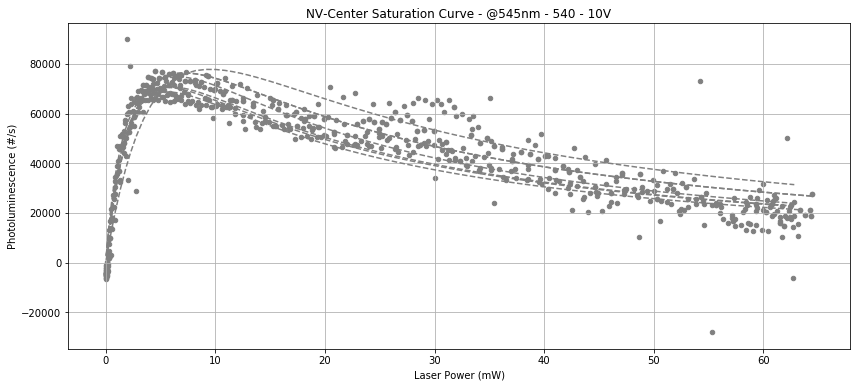

In [434]:
fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
for df in dfs_wavelength['540']['10V']: # experiment
	perform_fit_ax(daria_fit, ax1, df, 'grey')

ax1.set_title(f"NV-Center Saturation Curve - @{wavelength}nm - 540 - 10V")
ax1.set_xlabel("Laser Power (mW)")
ax1.set_ylabel("Photoluminescence (#/s)")

Text(0, 0.5, 'Photoluminescence (#/s)')

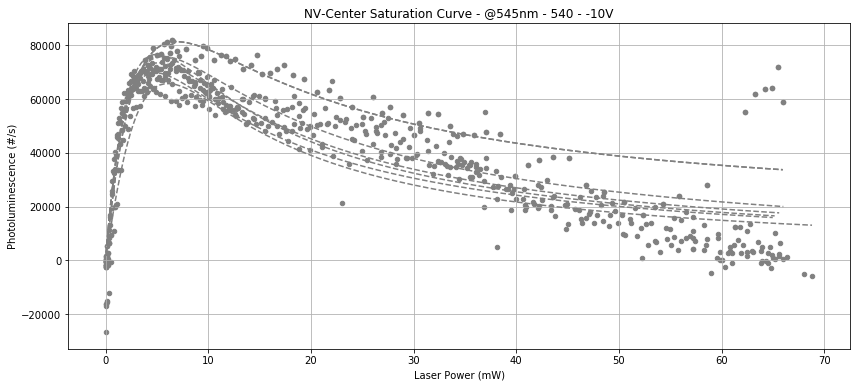

In [435]:
fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
for df in dfs_wavelength['540']['m10V']: # experiment
	perform_fit_ax(daria_fit, ax1, df, 'grey')

ax1.set_title(f"NV-Center Saturation Curve - @{wavelength}nm - 540 - -10V")
ax1.set_xlabel("Laser Power (mW)")
ax1.set_ylabel("Photoluminescence (#/s)")

Text(0, 0.5, 'Photoluminescence (#/s)')

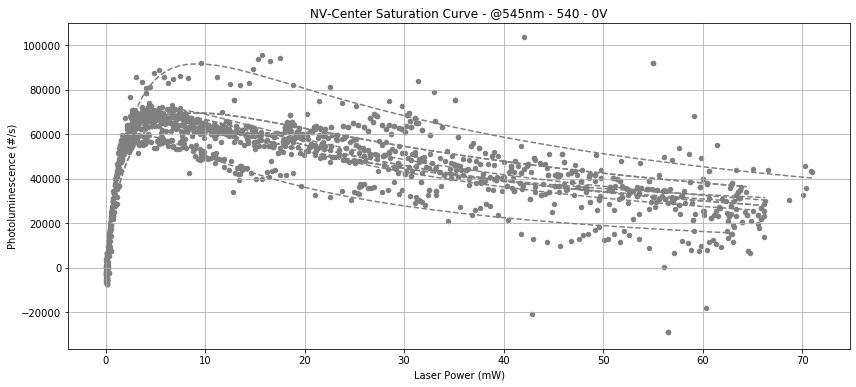

In [436]:
fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns
for df in dfs_wavelength['540']['0V']: # experiment
	perform_fit_ax(daria_fit, ax1, df, 'grey')

ax1.set_title(f"NV-Center Saturation Curve - @{wavelength}nm - 540 - 0V")
ax1.set_xlabel("Laser Power (mW)")
ax1.set_ylabel("Photoluminescence (#/s)")

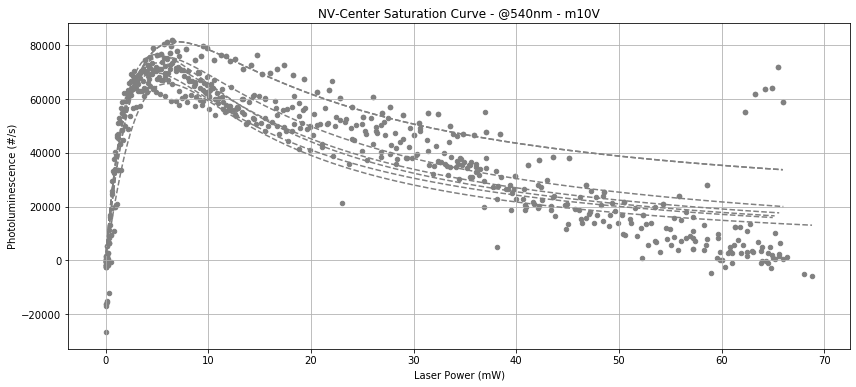

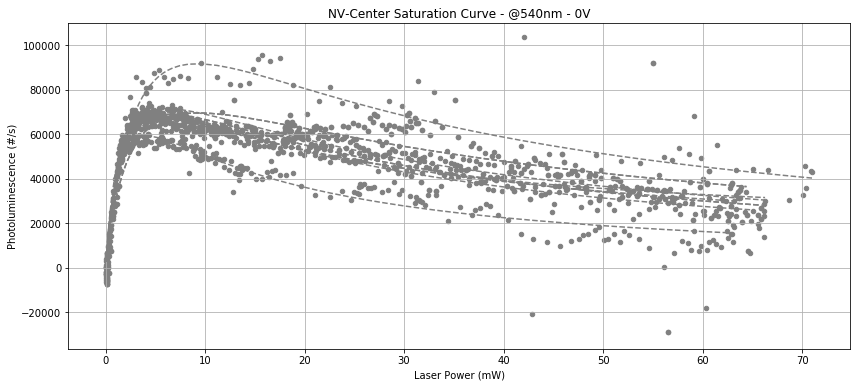

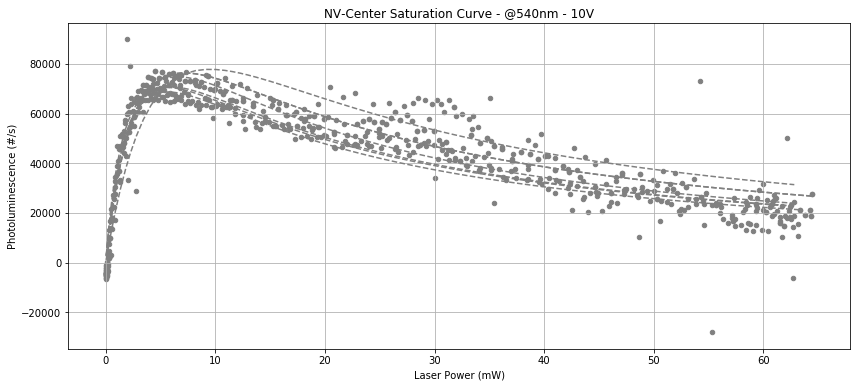

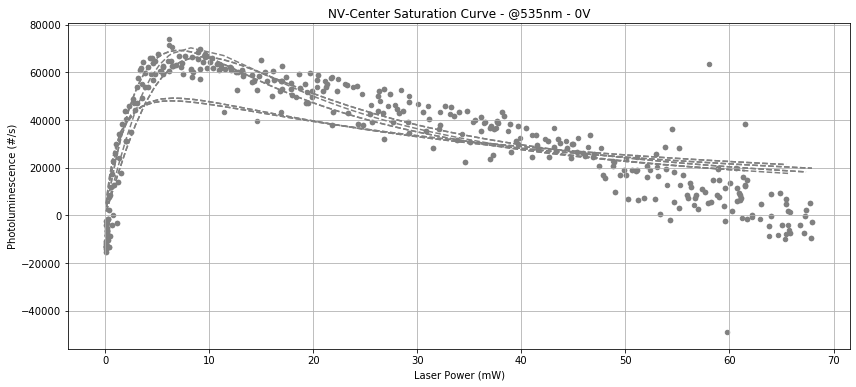

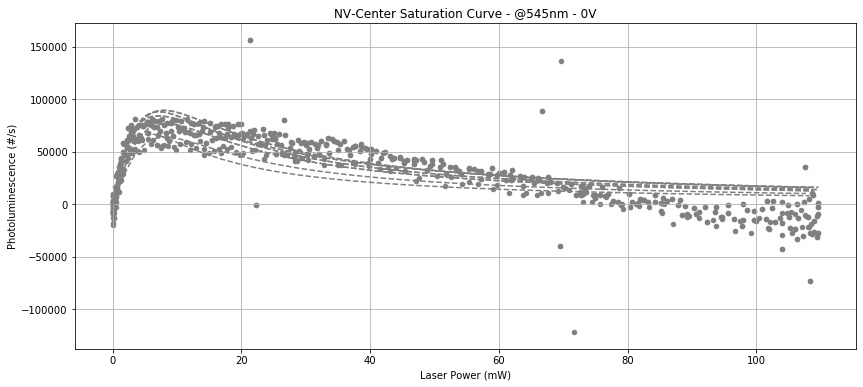

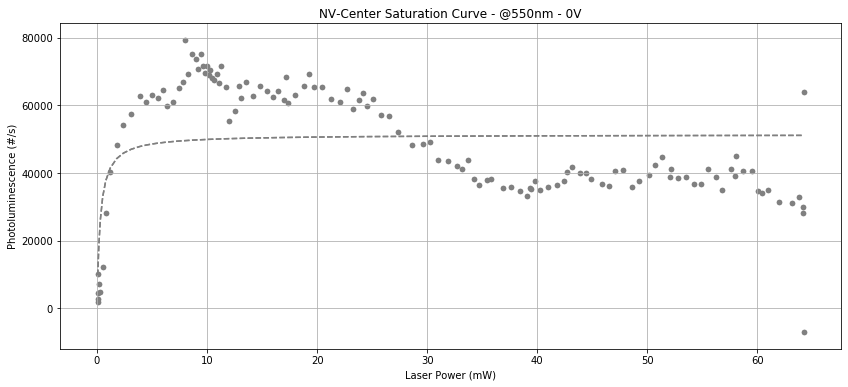

In [439]:
for w, voltages in dfs_wavelength.items(): # wavelength
	for v, experiments in voltages.items(): # voltage

		fig, (ax1) = plt.subplots(1,1, figsize=(14,6))  # 1 row, 2 columns

		for ii, df in enumerate(experiments): # experiment
			perform_fit_ax(daria_fit, ax1, df, 'grey')
			
			ax1.set_title(f"NV-Center Saturation Curve - @{w}nm - {v}")
			ax1.set_xlabel("Laser Power (mW)")
			ax1.set_ylabel("Photoluminescence (#/s)")